## Lab 3 Simulator

This Python code is a simulation of the propeller arm experiment used in Lab 3.  This code will output a text file of data in the same format as output by the data acquisition software used in lab.

The following cells only need to be run once to load libraries and define the constants of the system.

In [24]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
from matplotlib.animation import FuncAnimation

# system parameters
a = 0.75
m = 0.01
R0 = 0.01
R = 0.1
h = R/2
tht_min = np.arcsin(-h/R)
g = 9.8
b = 0.001
J = a*m*R**2
c1 = 2.0
c2 = np.log(c1)/h
thr_delay = 15

## Mathematical Model

In this lab, you will design feedback controllers to balance a pinned arm using a propeller at the tip, as shown in the following figure.

<img src="https://github.com/AdaWick/MEEG312/blob/master/Lab3/Rotating%20arm.png?raw=true"></img>

This system is inherently unstable: the arm will not remain horizontal unless there is a thrust force to balance the moment due to gravity.  The equations of motion (EOMs) can be found by taking a sum of moments about the pin (axis of rotation):

$\sum M_0 = J \ddot{\theta} = -b \dot{\theta} - mgR_0\cos(\theta) + TR$

which, upon rearranging, gives

$J \ddot{\theta} + b \dot{\theta} + mgR_0\cos(\theta) = TR$

This is a non-linear second-order ODE.  Moreover, the thrust $T$ is dependent on the distance $d$ to the ground, which is a function of the angle of the arm $\theta$.  Indeed, the closer the fan is to the ground, the more thrust it generates for a given fan speed.

Let's say the fan speed is $u$.  Then the thrust is given by

$T = c_1e^{-c_2d}u$

where $c_1, c_2$ are constants.  We can relate the distance $d$ to the arm's angle $\theta$ using geometry.  The result is

$ d = \dfrac{R\sin(\theta) + h}{\cos{\theta}}$

We want to control the speed of the fan $u$ so that the rotating arm tracks a sinusoidal motion.  The reference trajectory is what we want the system to track, in this case $r(t) = 0.3\sin(\omega t)$, where $\omega = \dfrac{2\pi}{4} rad/s$.

The error signal is $e(t) = r(t) - \theta(t)$, which ideally would be $0$ for all time.  Thus, the PID control law is given by

$u(t) = K_P e(t) + K_I \int_0^t e(t)dt + K_D \dfrac{de(t)}{dt}$

### Part 1: Manual Control

Run the following cell to start the simulation in which you can manually control the thrust of the propeller by using the slider on the right side.  Try to track the sinusoid path (stay between the lines) for at least 2 cycles.  This will give you a feel for how the system responds to inputs.

<IPython.core.display.Javascript object>


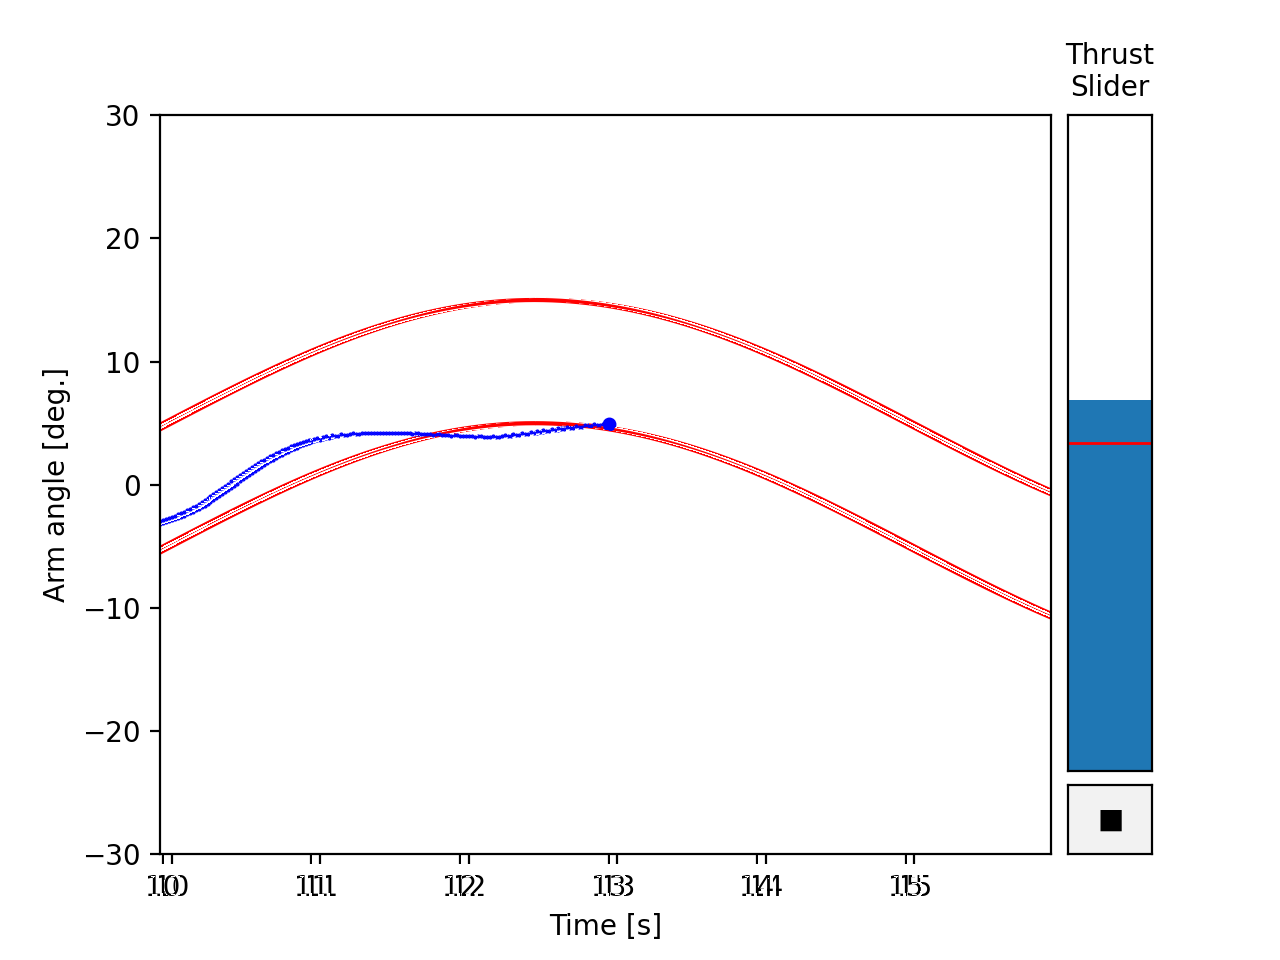

In [25]:
fig = plt.figure()
ax_plot = plt.subplot2grid((9, 10), (0, 0), rowspan=9, colspan=9)
ax_slider = plt.subplot2grid((9, 10), (0, 9), rowspan=8)
ax_button = plt.subplot2grid((9, 10), (8, 9))

#tht = 0
#d = (R*np.sin(tht)+h)/np.cos(tht)
#u = m*g*R0*np.cos(tht)/(c1*np.exp(-c2*d)*R)
#print(u)
#asdfafsad

# draw path
t_lead = 3               # time window forwards and backwards [s]
A = 10                   # path amplitude [deg]
w = 10                    # path width [deg]
T = 10                   # path period [s]
t_range = np.linspace(-t_lead,t_lead,101)
tht_upper = A*np.sin((2*np.pi/T)*t_range) + w/2
tht_lower = tht_upper - w
path_upper, = ax_plot.plot(t_range, tht_upper, 'r')
path_lower, = ax_plot.plot(t_range, tht_lower, 'r')
ax_plot.set_xlim([t_range[0],t_range[-1]])
ax_plot.set_ylim([180/np.pi*tht_min,-180/np.pi*tht_min])
ax_plot.set_ylabel('Arm angle [deg.]')
ax_plot.set_xlabel('Time [s]')

# draw point
t = [0]
tht = [0]
tht_dot = [0]
thrust = []
point, = ax_plot.plot(t, tht, 'b.', ms=8)

# draw trajectory
traj, = ax_plot.plot(t, tht, 'b.', ms=1)

# add thrust slider and stop button
h_slider = Slider(ax_slider, 'Thrust\nSlider', 0, 1, valinit=0.5, orientation='vertical')
h_button = Button(ax_button, label='$\u25A0$')

# simulation parameters
dt = 0.02
is_running = True


def play():
    global is_running
    ii = -1
    while is_running:
        ii = ii + 1
        yield ii

def stop(event=None):
    global is_running
    is_running = False
    
def update_plot(i):
    global t, tht, tht_dot, thrust
    
    # advance the path
    t_range = np.linspace(-t_lead,t_lead,101) + i*dt
    tht_upper = A*np.sin((2*np.pi/T)*t_range) + w/2
    tht_lower = tht_upper - w
    path_upper.set_data(t_range, tht_upper)
    path_lower.set_data(t_range, tht_lower)
    ax_plot.set_xlim([t_range[0], t_range[-1]])
    
    # calculate thrust based on slider input
    u = 2*0.0098*h_slider.val
    d = (R*np.sin(tht[i])+h)/np.cos(tht[i])
    thrust.append(c1*np.exp(-c2*d)*u)
    
    # update theta and theta dot
    tht_new = tht[i] + tht_dot[i]*dt
    if i < thr_delay:
        thr = 2*0.0098*0.5*c1*np.exp(-c2*d)
        tht_dot_new = tht_dot[i] + (-b*tht_dot[i] - m*g*R0*np.cos(tht[i]) + R*thr)/J*dt
    else:
        tht_dot_new = tht_dot[i] + (-b*tht_dot[i] - m*g*R0*np.cos(tht[i]) + R*thrust[i-thr_delay])/J*dt
    
    # if theta is below the minimum, it "bounces" off the ground
    if tht_new < tht_min:
        tht_new = 2.0*tht_min - tht_new
        tht_dot_new = -0.1*tht_dot_new
        
    # move the point
    t.append(t[i] + dt)
    tht.append(tht_new)
    tht_dot.append(tht_dot_new)
    point.set_data(t[-1], 180/np.pi*tht[-1])
    
    # add to the trajectory
    traj.set_data(t, 180/np.pi*np.array(tht))


h_button.on_clicked(stop)

ani = FuncAnimation(fig, update_plot, frames=play(), interval=dt*1000, blit=False, repeat=False)

Run the following cell to see a time history of your trajectory and the thrust input from the slider.

<IPython.core.display.Javascript object>


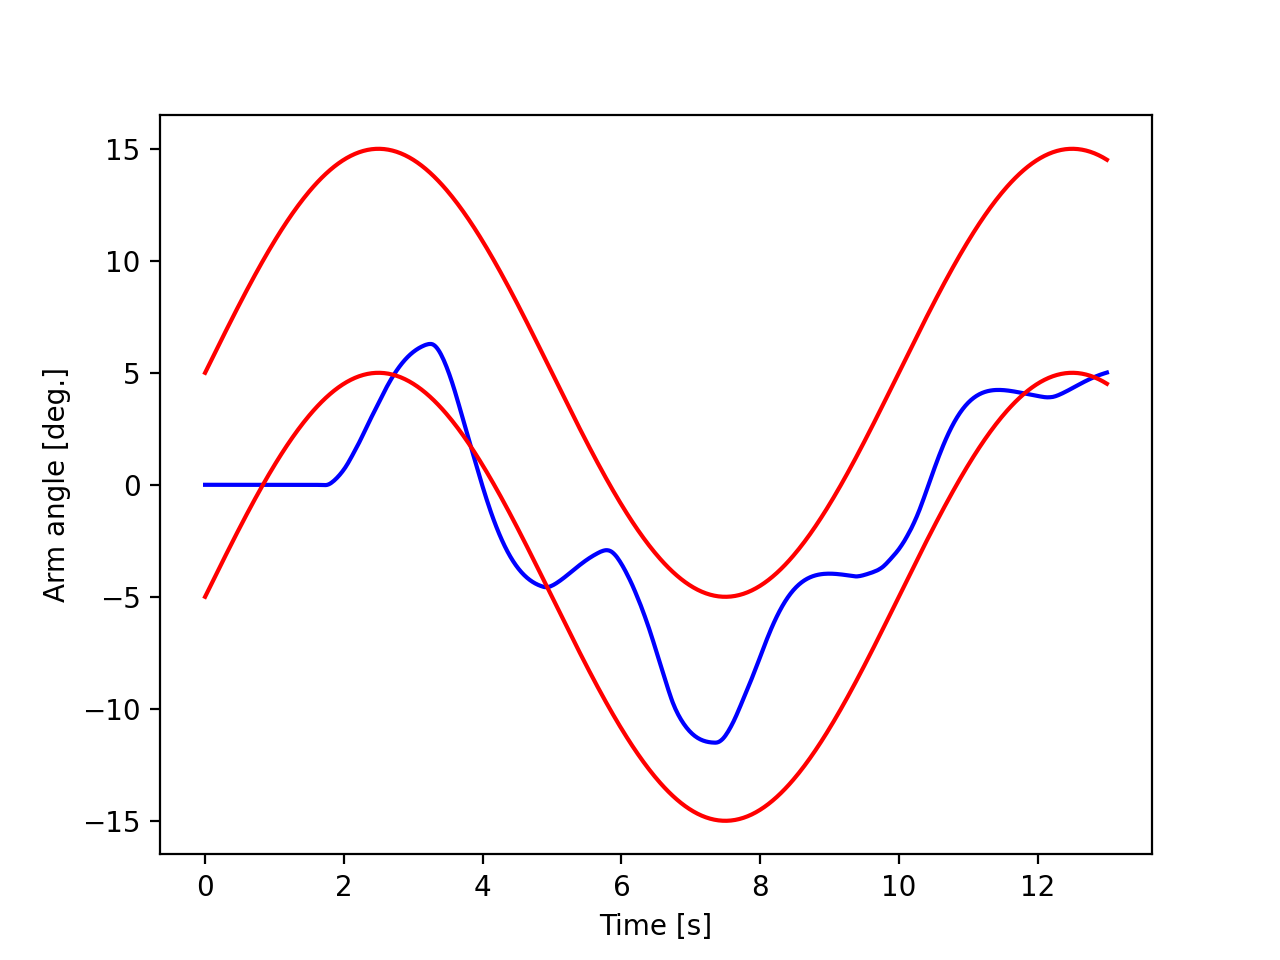

<IPython.core.display.Javascript object>


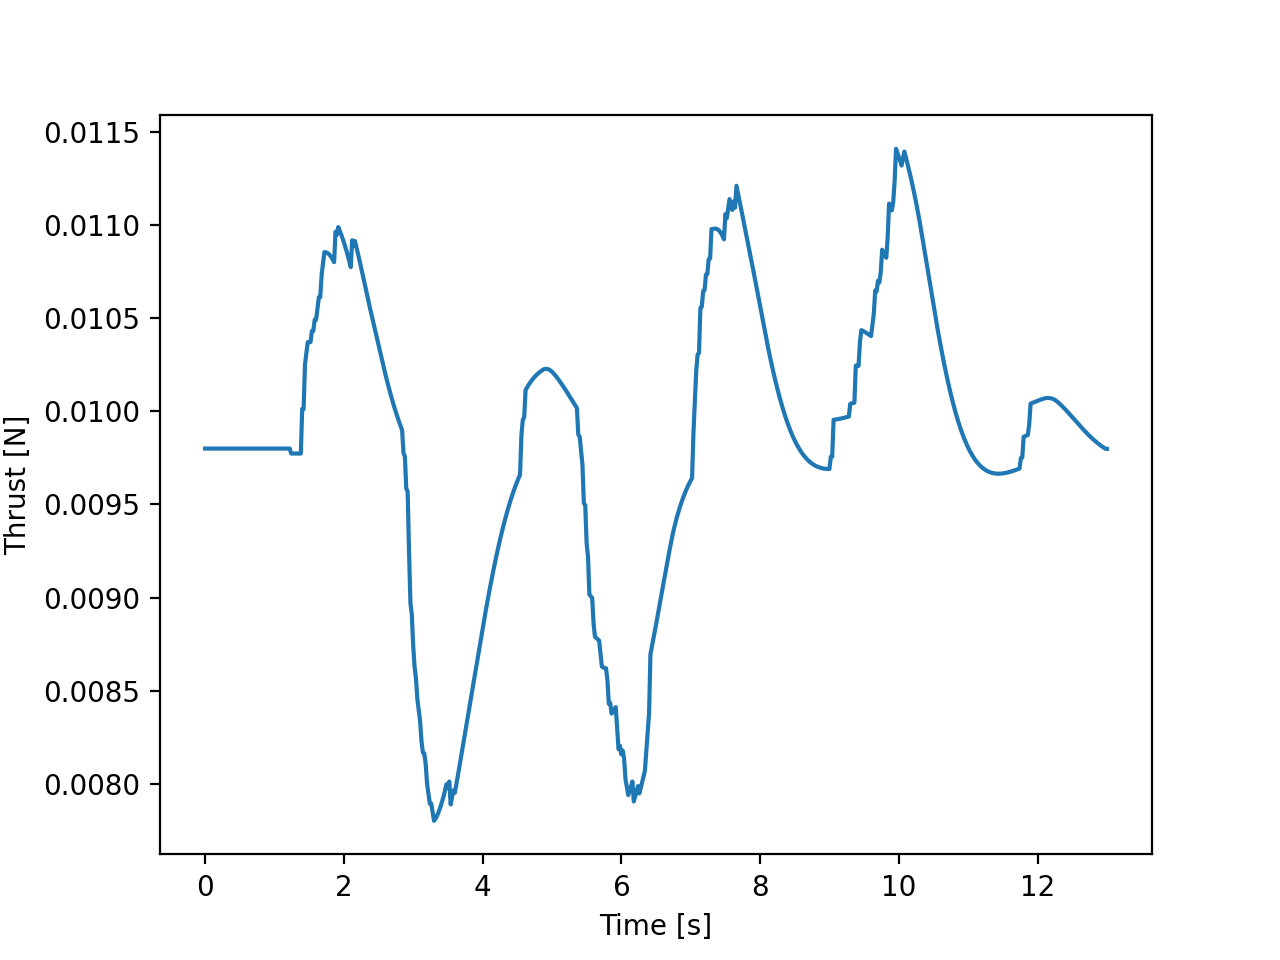

In [26]:
t = np.array(t)
tht = np.array(tht)
tht_upper = A*np.sin((2*np.pi/T)*t) + w/2
tht_lower = tht_upper - w
thrust.append(thrust[-1])
thrust = np.array(thrust)

plt.figure()
plt.plot(t,(180/np.pi)*tht,'b',t,tht_upper,'r',t,tht_lower,'r')
plt.ylabel('Arm angle [deg.]')
plt.xlabel('Time [s]')

plt.figure()
plt.plot(t,thrust)
plt.ylabel('Thrust [N]')
plt.xlabel('Time [s]');

When you're satisfied with your results, run the following cell to save your data in a text file in the current folder.  This file will contain time in seconds, motor command (converted to volts input to the motor), and desired and actual positions (converted to volts measured by the Hall Effect sensor).

In [ ]:
dataout = np.zeros((t.size,4))
dataout[:,0] = t
dataout[:,1] = 1000*thrust - 2.5
dataout[:,2] = (tht_upper-w/2)/5 + 2
dataout[:,3] = tht/5 + 2

print('Enter file name for saving data (without extension):')
filename = input()+'.txt'
np.savetxt(filename,dataout,comments='',fmt=['%2.3f','%2.3f','%2.3f','%2.3f'],delimiter='\t',header='Time (s)\tMotor Command (V)\tDesired Position (V)\tActual Position (V)')

### Part 2: PID Control

The following code implements a [Proportional, Integral, Derivative (PID) controller](https://en.wikipedia.org/wiki/PID_controller) in a closed-loop simulation of the rotating arm.

Set your controller gains at the top of the following cell, then run it to start the closed-loop simulation.  In this simulation, the controller tries to stabilize the arm in the horizontal position ($\theta = 0$).

<IPython.core.display.Javascript object>


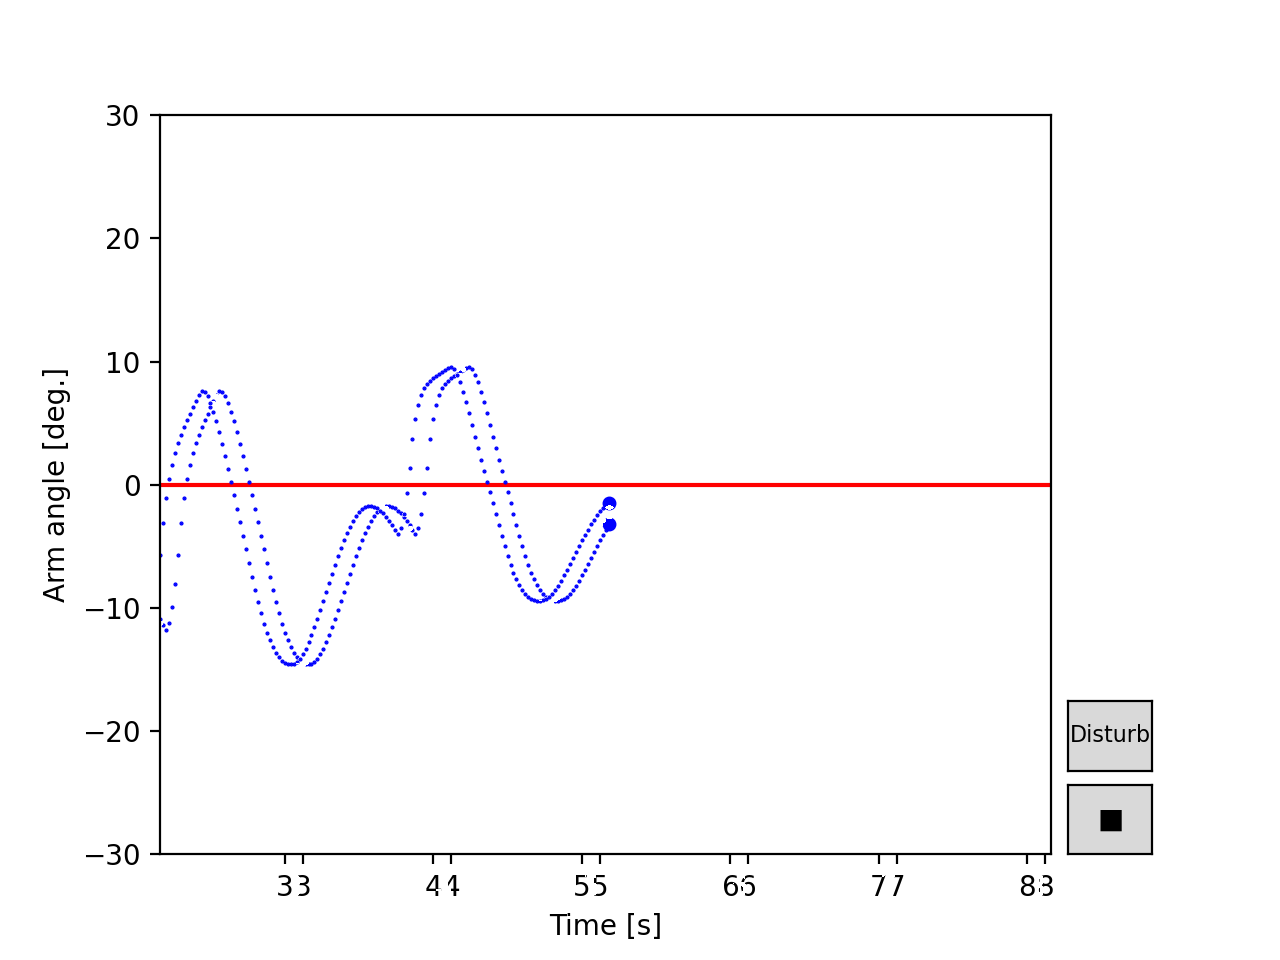

In [47]:
# PID control gains
KP = 0.0
KI = 0.0
KD = 0.0

fig = plt.figure()
ax_plot = plt.subplot2grid((9, 10), (0, 0), rowspan=9, colspan=9)
ax_disturb = plt.subplot2grid((9, 10), (7, 9))
ax_stop = plt.subplot2grid((9, 10), (8, 9))

# draw path
t_lead = 3               # time window forwards and backwards [s]
t_range = np.linspace(-t_lead,t_lead,101)
tht_desired = np.zeros_like(t_range)
path_desired, = ax_plot.plot(t_range, tht_desired, 'r')
ax_plot.set_xlim([t_range[0],t_range[-1]])
ax_plot.set_ylim([180/np.pi*tht_min,-180/np.pi*tht_min])
ax_plot.set_ylabel('Arm angle [deg.]')
ax_plot.set_xlabel('Time [s]')

# draw point
t = [0]
tht = [0]
tht_dot = [0]
e = []
I = 0
thrust = []
disturb_count = 0
disturb_mag = 0.003
point, = ax_plot.plot(t, tht, 'b.', ms=8)

# draw trajectory
traj, = ax_plot.plot(t, tht, 'b.', ms=1)

# add disturb and stop buttons
h_disturb = Button(ax_disturb, label='Disturb')
h_disturb.label.set_fontsize(8)
h_stop = Button(ax_stop, label='$\u25A0$')

# simulation parameters
dt = 0.02
is_running = True


def play():
    global is_running
    ii = -1
    while is_running:
        ii = ii + 1
        yield ii

def disturb(event=None):
    #global tht
    #tht[-1] = tht[-1] + 10*np.pi/180
    global disturb_count
    disturb_count = 5
    
def stop(event=None):
    global is_running
    is_running = False
    
def update_plot(i):
    global t, tht, tht_dot, thrust, e, I, disturb_count
    
    # advance the path
    t_range = np.linspace(-t_lead,t_lead,101) + i*dt
    path_desired.set_data(t_range, tht_desired)
    ax_plot.set_xlim([t_range[0], t_range[-1]])
    
    # calculate thrust based on slider input
    e.append(-tht[i])                              # compute error
    I = I + e[i]*dt                                # update integral running sum
    if i == 0:
        u = KP*e[i] + KI*I                         # controller without derivative term
    else:
        u = KP*e[i] + KD*(e[i]-e[i-1])/dt + KI*I   # controller
    u = np.maximum(u,0.0)/100                      # make sure thrust is not negative
    d = (R*np.sin(tht[i])+h)/np.cos(tht[i])
    thrust.append(c1*np.exp(-c2*d)*u)
    
    # update theta and theta dot
    tht_new = tht[i] + tht_dot[i]*dt
    if i < thr_delay:
        thr = 2*0.0098*0.5*c1*np.exp(-c2*d)
        tht_dot_new = tht_dot[i] + (-b*tht_dot[i] - m*g*R0*np.cos(tht[i]) + R*thr)/J*dt
    else:
        if disturb_count > 0:
            disturb_count = disturb_count - 1
            tht_dot_new = tht_dot[i] + (-b*tht_dot[i] - m*g*R0*np.cos(tht[i]) + R*thrust[i-thr_delay] + disturb_mag)/J*dt
        else:
            tht_dot_new = tht_dot[i] + (-b*tht_dot[i] - m*g*R0*np.cos(tht[i]) + R*thrust[i-thr_delay])/J*dt
    
    # if theta is below the minimum, it "bounces" off the ground
    if tht_new < tht_min:
        tht_new = 2.0*tht_min - tht_new
        tht_dot_new = -0.1*tht_dot_new
        
    # move the point
    t.append(t[i] + dt)
    tht.append(tht_new)
    tht_dot.append(tht_dot_new)
    point.set_data(t[-1], 180/np.pi*tht[-1])
    
    # add to the trajectory
    traj.set_data(t, 180/np.pi*np.array(tht))


h_disturb.on_clicked(disturb)
h_stop.on_clicked(stop)

ani = FuncAnimation(fig, update_plot, frames=play(), interval=dt*1000, blit=False, repeat=False)

Run the following cell to see a time history of your trajectory and the thrust input from the PID controller.

<IPython.core.display.Javascript object>


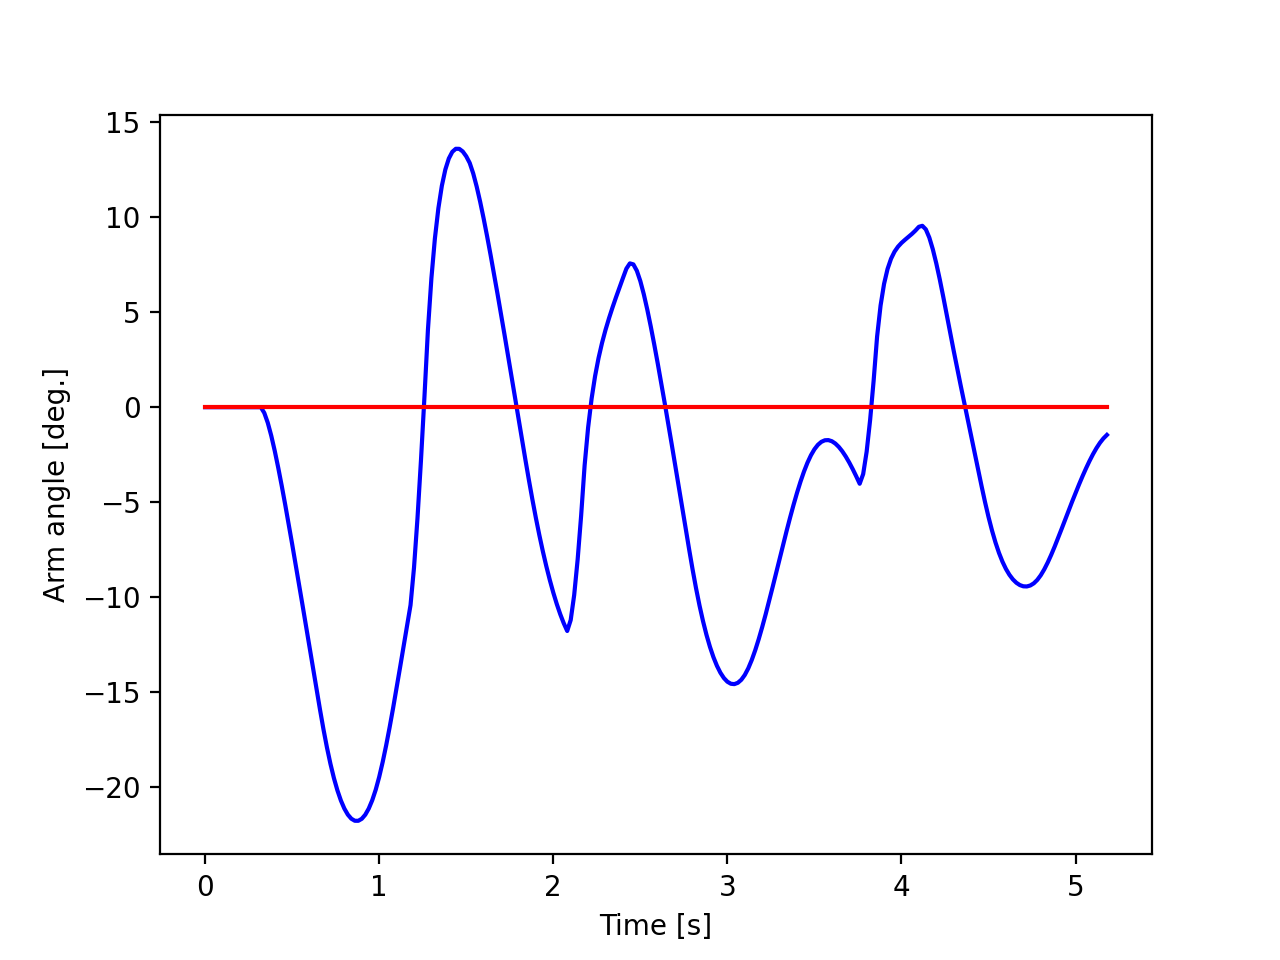

<IPython.core.display.Javascript object>


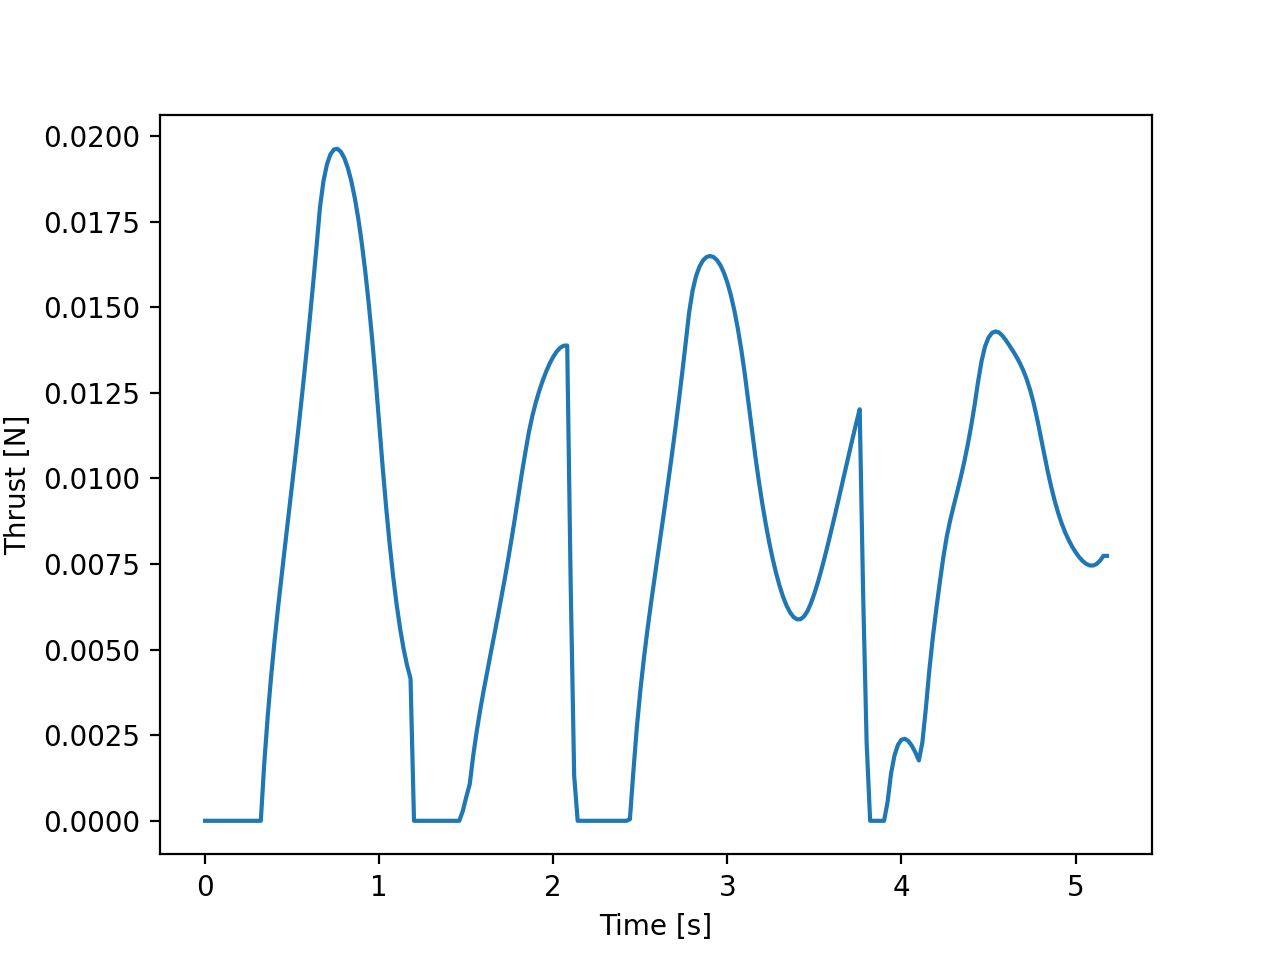

In [48]:
t = np.array(t)
tht = np.array(tht)
tht_desired = np.zeros_like(t)
thrust.append(thrust[-1])
thrust = np.array(thrust)

plt.figure()
plt.plot(t,(180/np.pi)*tht,'b',t,tht_desired,'r')
plt.ylabel('Arm angle [deg.]')
plt.xlabel('Time [s]')

plt.figure()
plt.plot(t,thrust)
plt.ylabel('Thrust [N]')
plt.xlabel('Time [s]');

Run the following cell to save your data in a text file in the current folder.  This file will contain time in seconds, motor command (converted to volts input to the motor), and desired and actual positions (converted to volts measured by the Hall Effect sensor).

In [ ]:
dataout = np.zeros((t.size,4))
dataout[:,0] = t
dataout[:,1] = 1000*thrust - 2.5
dataout[:,2] = (tht_upper-w/2)/5 + 2
dataout[:,3] = tht/5 + 2

print('Enter file name for saving data (without extension):')
filename = input()+'.txt'
np.savetxt(filename,dataout,comments='',fmt=['%2.3f','%2.3f','%2.3f','%2.3f'],delimiter='\t',header='Time (s)\tMotor Command (V)\tDesired Position (V)\tActual Position (V)')